**<font size=5>Tennessee Fuel Quality Analysis</font>**

* **Date Published**: 2019/07/31
* **Collaborators**: [Kate Hayes](https://github.com/99KHayes) & [Misha Berrien](https://github.com/mishaberrien)
* **Data Source**: State of Tennessee Department of Agriculture

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
import sklearn.preprocessing as preprocessing
import statsmodels.api as sm
import sys

from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN


src_dir = os.path.join(os.getcwd(), '..', '..', 'src')
sys.path.append(src_dir)

# helper functions 
from d03_processing.feature_engineering import process_data_for_model_building
from d04_modelling.modelling import get_model_pvalue

# Load the "autoreload" extension
%load_ext autoreload

# reload modules so that as you change code in src, it gets loaded
%autoreload

%matplotlib inline

## Introduction 

## Dataset

Five year fuel quality inspection records
for the state of Tennessee

* Source: State of Tennessee Department of Agriculture
* Time Period: Mid 2014 to early 2019
* Number of Fuel Products: 11
* Number of Test Types: 72

## Key Metrics

* Distillation 50% - The temperature at which 50% of a sample is evaporated. Relates to the driveability and idling characteristics for the fuel.
* Vapor Pressure - is a measure of the amount of vapor that is produced by a gasoline sample at 37.8°C (100°F). Vapor pressure most affects an engine’s ease of starting.
* Vapor-liquid ratio is the ratio of the volume of vapor to the volume of liquid at atmospheric pressure.Used to evaluate a gasoline sample’s tolerance to changes in temperature.

## Questions

Can we use data collected by fuel inspectors to better predict gas station fuel test failures in the state
of Tennessee?

## Time Series Analysis

### Summary & Caveats

## Logistic Regression Analysis

### Load and Process Datasets

The helper functions for cleaning/ processing the dataset can be found in the src/d03_processing folder

In [2]:
gasoline_proc = pd.read_csv('../../data/03_processed/gasoline_processed.csv')
astm = pd.read_csv('../../data/01_raw/ASTM_fuel.csv')
astm.columns = ['Date', 'TN_retailers_seasons', 'TN_distributor_seasons',
       'vapor_liquid_minC_retail', 'distillation_50_minC _retail',
       'distillation_50_maxC_retail', 'vapor_pressure_maxC_retail',
       'vapor_liquid_minC_dist', 'distillation_50_minC_dist',
       'distillation_50_maxC_dist', 'vapor_pressure_maxC_dist']

In [3]:
gasoline = process_data_for_model_building(gasoline_proc, astm)

### Build & Choose Model

#### Define Variables

In [4]:
# construct features 
x_feats = ['grade']
X = pd.get_dummies(gasoline[x_feats], dtype=float)
X = sm.tools.add_constant(X)
# convert target using get_dummies
y = pd.get_dummies(gasoline["compliance_vap_liq_pressure"], dtype=float)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y.iloc[:,0], test_size=0.3, random_state=0)

Our dataset is heavily imbalanced with a 26:9062 ratio of 1 to 0s. In order to find a reliable result, we need to balance these numbers with oversampling. 

In [6]:
print("Label Count '1': {}".format(sum(y_train==1)))
print("Label Count '0': {} \n".format(sum(y_train==0)))

Label Count '1': 26
Label Count '0': 9062 



#### Oversampling

In [7]:
smote = SMOTE()

# simple resampling from your previously split data
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train.ravel())

In [8]:
print("Label Count '1': {}".format(sum(y_train_resampled==1)))
print("Label Count '0': {} \n".format(sum(y_train_resampled==0)))

Label Count '1': 9062
Label Count '0': 9062 



We now have a balanced dataset to build our models with. 

#### Model 1: Vapor Liquid-Ratio Test Outcome ~ Grade

In [9]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12)
model_log = logreg.fit(X_train_resampled, y_train_resampled)
model_log

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Let's find our pvalues

In [10]:
get_model_pvalue(y_train_resampled, X_train_resampled)

         Current function value: 0.637993
         Iterations: 35

 PValues for model parameters: 
 [       nan        nan        nan 0.99999237        nan]


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


These pvalues are not significant. Let's try another model. 

#### Model 2: Vapor Liquid-Ratio Test Outcome ~ Tennessee Retailers Season & Grade

We will repeat the process laid out above for our second model

In [11]:
# construct features 
x_feats = ['TN_retailers_seasons', 'grade']
X = pd.get_dummies(gasoline[x_feats], dtype=float)
X = sm.tools.add_constant(X)
# convert target using get_dummies
y = pd.get_dummies(gasoline["compliance_vap_liq_pressure"], dtype=float)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y.iloc[:,0], test_size=0.3, random_state=0)

In [13]:
smote = SMOTE()

# simple resampling from your previously split data
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train.ravel())

In [14]:
# simple resampling from your previously split data
X_test_resampled, y_test_resampled = smote.fit_sample(X_test, y_test.ravel())

In [15]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12)
model_log = logreg.fit(X_train_resampled, y_train_resampled)
model_log

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
get_model_pvalue(y_train_resampled, X_train_resampled)

         Current function value: 0.419943
         Iterations: 35

 PValues for model parameters: 
 [0.99994706 0.99996276 0.99999999 0.99996123 0.99996005 0.99997637
 0.9999604  1.         0.99999999 0.99999402 0.99999488 0.99997355
 0.99999646]


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Neither of our models have significant pvalues, but, since we want to understand a bit better about blah blah blah blah, we are going to choose the second model (which have slightly higher pvalues) and move on to our testing phase. 

### Test the Chosen Model (Prediction) 

In [17]:
y_hat_test_resampled = logreg.predict(X_test_resampled)
y_hat_train_resampled = logreg.predict(X_train_resampled)

#### Precision, Recall, Accuracy and F1-Score

In [18]:
print('Training Precision: ', precision_score(y_hat_train_resampled, y_train_resampled))
print('Testing Precision: ', precision_score(y_hat_test_resampled, y_test_resampled))
print('\n\n')

print('Training Recall: ', recall_score(y_hat_train_resampled, y_train_resampled))
print('Testing Recall: ', recall_score(y_hat_test_resampled, y_test_resampled))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_hat_train_resampled, y_train_resampled))
print('Testing Accuracy: ', accuracy_score(y_hat_test_resampled, y_test_resampled))
print('\n\n')

print('Training F1-Score: ',f1_score(y_hat_train_resampled, y_train_resampled))
print('Testing F1-Score: ',f1_score(y_hat_test_resampled, y_test_resampled))

Training Precision:  0.882696976384904
Testing Precision:  0.9515962924819773



Training Recall:  0.7476399663519955
Testing Recall:  0.767601246105919



Training Accuracy:  0.7923747517104393
Testing Accuracy:  0.831745623069001



Training F1-Score:  0.809574414250291
Testing F1-Score:  0.8497528451546154


#### ROC Curve & AUC

In [19]:
#First calculate the probability scores of each of the datapoints:
y_score = logreg.fit(X_train_resampled, y_train_resampled).decision_function(X_test_resampled)

fpr, tpr, thresholds = roc_curve(y_test_resampled, y_score)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.889331784203275


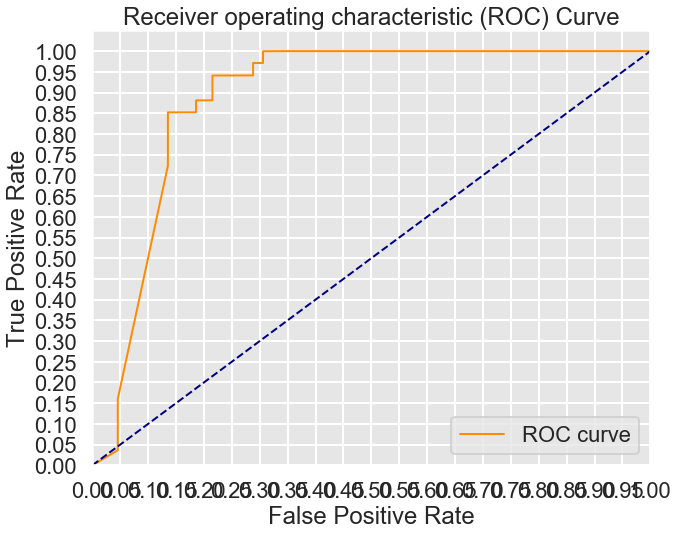

In [20]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context('poster')
print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("../../results/Images/roc.jpg")

### Summary & Caveats

BLAH BLAH BLAH 

## Conclusion & Next Steps

* There is obvious seasonal trends due to the nature of the regulations.
* Further analysis is required in order to interpret the logistic regression.
* Do tests that pass but barely pass lead to more complaints?
* Do certain regions of Tennessee have more failures in certain seasons
* Do certain brands of gas stations or distributors deliver more failures or have more complaints against them?